In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import plotly.express as px


In [3]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
lag = 41
process = 2


In [4]:
# df = pd.read_hdf(f'../{protein}/summary_batch1.h5', key='timescale_ratio')

In [17]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5', f'../{protein}/summary_batch3.h5']

hp_paths = ['../../experiments/hpsample.h5', '../../experiments/new_hpsample.h5', '../../experiments/new_ts_hpsample_missing_best.h5']

keep_hp_ixs = [np.array([]), np.array([329, 330, 331, 334, 335]), 
               np.array([340, 341, 342, 343, 344])]

hps = []
timescales = []
gaps = []
for batch_num in range(3):
    keep_ix = keep_hp_ixs[batch_num]
    
    # Hp definitions
    hp = pd.read_hdf(hp_paths[batch_num])
    hp.reset_index(inplace=True)    
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in hp.columns:
            hp.drop(labels=[drop_col], inplace=True, axis=1)
    if keep_ix.shape[0]>0: 
        hp = hp.loc[hp.hp_ix.isin(keep_ix), :]
    hps.append(hp)
    
    # timescales
    tmp = pd.read_hdf(summary_paths[batch_num], key='timescales')
    tmp.reset_index(inplace=True)
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in tmp.columns:
            tmp.drop(labels=[drop_col], inplace=True, axis=1)
    
    if keep_ix.shape[0]>0: 
        tmp = tmp.loc[tmp.hp_ix.isin(keep_ix), :]
    timescales.append(tmp)

    
    # gaps
    tmp = pd.read_hdf(summary_paths[batch_num], key='timescale_ratio')
    tmp.reset_index(inplace=True)
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in tmp.columns:
            tmp.drop(labels=[drop_col], inplace=True, axis=1)
    
    if keep_ix.shape[0]>0: 
        tmp = tmp.loc[tmp.hp_ix.isin(keep_ix), :]
    gaps.append(tmp)    
       
        
        
timescales = pd.concat(timescales, axis=0)
gaps = pd.concat(gaps, axis=0)
hps = pd.concat(hps, axis=0)    

print(timescales.shape, hps.shape, gaps.shape)

timescales = timescales.merge(hps, on=['hp_ix'], how='left')
timescales = timescales.merge(gaps, on=['hp_ix', 'lag', 'process'], how='left')

timescales['feature'] = timescales.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)
print(timescales.shape)
timescales.drop_duplicates(inplace=True)
print(timescales.shape)


timescales.sort_values(by=['hp_ix', 'lag', 'process'], inplace=True)
timescales['cum_ts'] = timescales.groupby(['hp_ix', 'lag'])['median_x'].cumsum()

(68161, 7) (150, 14) (68161, 7)
(68161, 25)
(68161, 25)


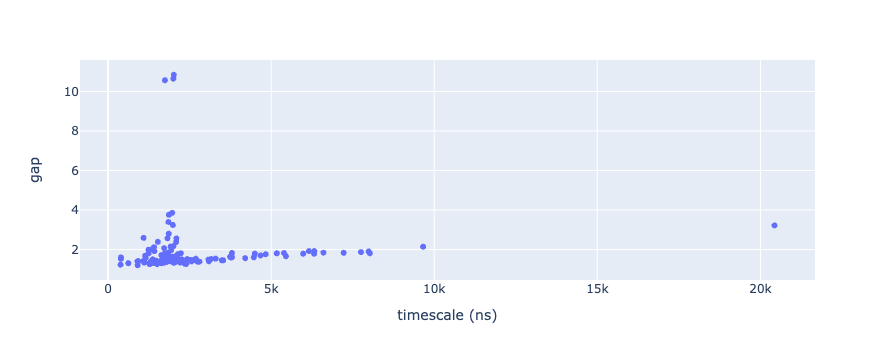

In [18]:
data=timescales.query("process==2").query('lag==41').query('hp_ix < 329')

# df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(data, x="median_x", y="median_y", hover_data=['hp_ix', 'feature', 'tica__lag', 'tica__dim', 'cluster__k'], 
                labels={
                     "cum_ts": "cum. timescale (ns)",
                     "median_y": "gap",
                    "median_x": 'timescale (ns)'
                 })
fig.show()

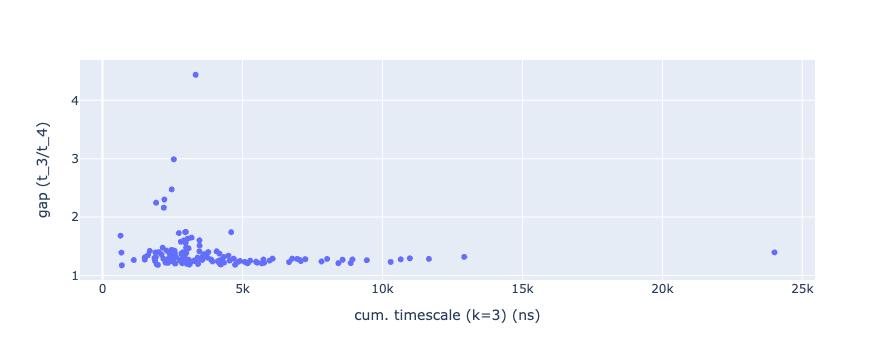

In [20]:
k = 3
data=timescales.query(f"process=={k}").query('lag==41').query('hp_ix < 329')

# df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(data, x="cum_ts", y="median_y", hover_data=['hp_ix', 'feature', 'tica__lag', 'tica__dim', 'cluster__k'], 
                labels={
                     "cum_ts": f"cum. timescale (k={k}) (ns)",
                     "median_y": f"gap (t_{k}/t_{k+1})",
                    "median_x": 'timescale (ns)'
                 })
fig.show()